In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shapely

import sprawl
from sprawl import plotting

In [4]:
sample = sprawl.HDF5('../../inputs/hdf5s/BICCN_mouse1sample1.hdf5')
sample

HDF5 ../../inputs/hdf5s/BICCN_mouse1sample1.hdf5

In [31]:
#Calculate the mean area per cell for 10,000 cells in m1s1

%%time
from tqdm import tqdm
cell_id_to_mean_area = {}
max_cells = 10000

for i,cell in tqdm(enumerate(sample.iter_cells())):
    mean_area = np.mean([shapely.geometry.Polygon(b).area for z,b in cell.boundaries.items()])
    cell_id_to_mean_area[cell.cell_id] = mean_area
    
    if max_cells and i >= max_cells-1:
        break
    
cell_id_to_mean_area

9999it [08:08, 20.47it/s] 


CPU times: user 1min 3s, sys: 9.7 s, total: 1min 12s
Wall time: 8min 8s


{'222098490380092065288492113826920653088': 176.85498760451765,
 '219317688036597170359303314569663425985': 40.04365885874295,
 '22824047249550318065337161594065658005': 54.556454051075306,
 '64814073103859609953676170799955707821': 39.12051271061067,
 '176101836528363994000204529222111284714': 14.896721874110614,
 '219002711125808771338247530625455951783': 223.5392713381966,
 '145385588681211774057078196988290042665': 134.68366287588404,
 '324936583968035907461485415440119465532': 98.74502095202489,
 '127044196217011089032016993149916982005': 74.10047311121903,
 '183802642346066446813406098680505493496': 24.58006394429154,
 '212380056445062369967464310553750468306': 161.16735557592463,
 '221289682902357401036682032218061808921': 140.4330612155499,
 '227833902103094513653469756064354589296': 166.20934544592396,
 '305898754230419262852035600841537319492': 54.97291138150327,
 '34723182058924265408073791811691302037': 135.45753690401932,
 '274906184032831930433419131495222241441': 45.6955

In [37]:
#Merge cell-area with SPRAWL score
import glob

cell_paths = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_cell/BICCN_mouse1_*_gene_cell.csv')

cell_scores_df = pd.concat(pd.read_csv(cp) for cp in cell_paths)
cell_scores_df['mean_area'] = cell_scores_df['cell_id'].map(cell_id_to_mean_area)
cell_scores_df.dropna(inplace=True)
cell_scores_df

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,score,variance,experiment,sample,mean_area
0,puncta,208216926404047031835800982290964847257,Endo,197,Cxcl14,3,-0.488000,0.334000,BICCN_mouse1,m1s1,143.383103
1,puncta,208216926404047031835800982290964847257,Endo,197,Flt1,66,0.458000,0.334000,BICCN_mouse1,m1s1,143.383103
2,puncta,208216926404047031835800982290964847257,Endo,197,Aqp4,2,-0.250000,0.334000,BICCN_mouse1,m1s1,143.383103
3,puncta,208216926404047031835800982290964847257,Endo,197,Acta2,3,-0.848000,0.334000,BICCN_mouse1,m1s1,143.383103
4,puncta,208216926404047031835800982290964847257,Endo,197,Timp3,17,0.566000,0.334000,BICCN_mouse1,m1s1,143.383103
...,...,...,...,...,...,...,...,...,...,...,...
425200,central,123587345114905858213705535160025836709,SMC,222,Trp53i11,1,0.628959,0.336350,BICCN_mouse1,m1s1,65.986366
425201,central,123587345114905858213705535160025836709,SMC,222,Tshz2,2,-0.199095,0.167414,BICCN_mouse1,m1s1,65.986366
425202,central,123587345114905858213705535160025836709,SMC,222,Unc5b,3,-0.194570,0.199984,BICCN_mouse1,m1s1,65.986366
425203,central,123587345114905858213705535160025836709,SMC,222,Vtn,4,-0.271493,0.132714,BICCN_mouse1,m1s1,65.986366


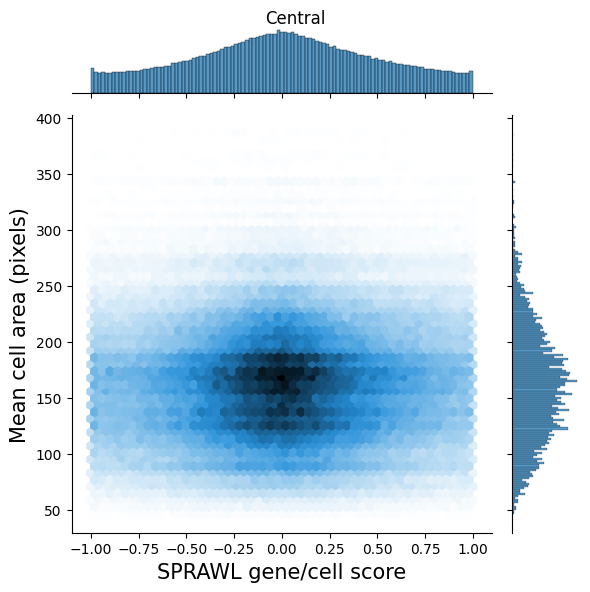

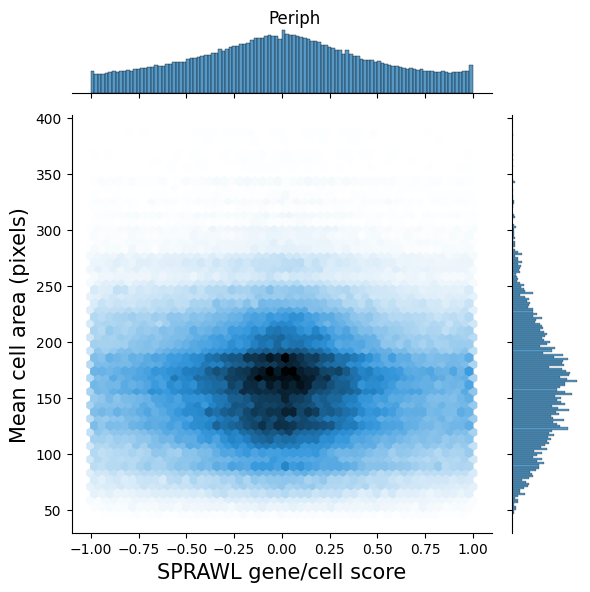

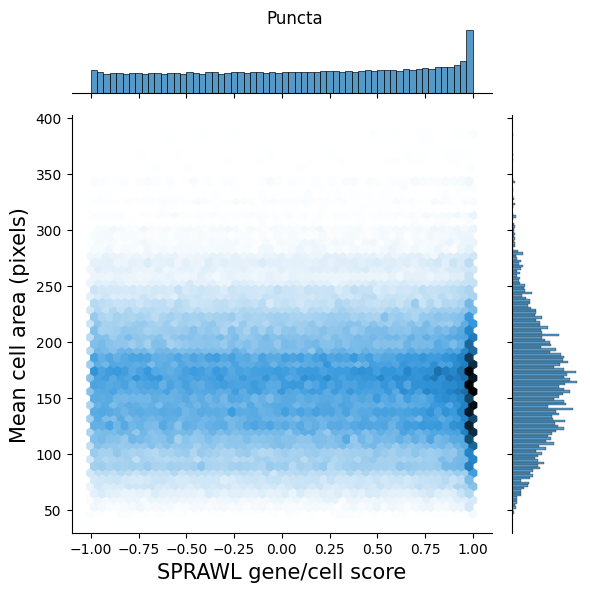

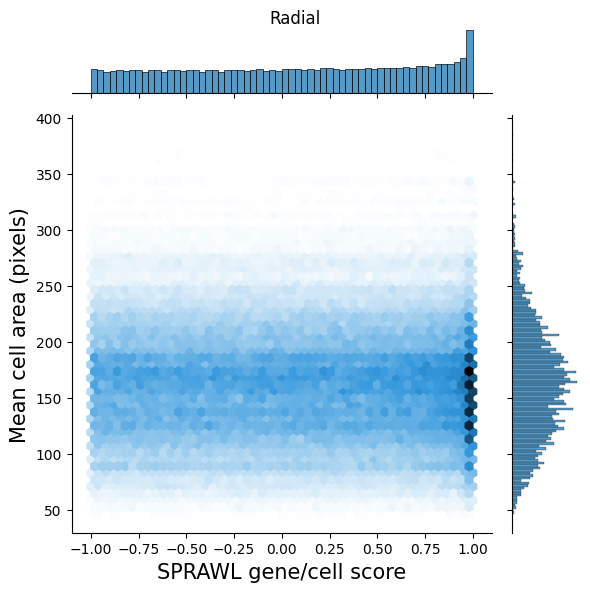

In [47]:
for metric,plot_df in cell_scores_df.groupby('metric'):
    j_ax = sns.jointplot(
        x = 'score',
        y = 'mean_area',
        kind = 'hex',
        data = plot_df,
    )
    j_ax.ax_joint.set_xlabel('SPRAWL gene/cell score', fontsize=15)
    j_ax.ax_joint.set_ylabel('Mean cell area (pixels)', fontsize=15)
    j_ax.fig.tight_layout()
    j_ax.fig.subplots_adjust(top=0.95)
    plt.suptitle(metric.capitalize())
    plt.savefig(f'cell_size_effect_plots/cell_size_effect_score_{metric}.svg')
    plt.show()
    plt.close()
    